## 2021 Emory REU/RET: PyTorch Segmentation Model

    Elle Buser
    7/29/21

Model:

- Input: Tensor of size [n, 3, 256, 256] where n is the number of DENSE image sets.

      -3 corresponds to number of channels: magnitude, mean DENSE, and peak DENSE images respectively. 

      -256, 256 is image size.

- Output: Tensor of size [n, 3, 256, 256]

      -3 corresponds to the number of classes in the segmentation: background, cerebellum, and brain stem.

Function: segment(DENSE_image, 'model_path', 'save_path', model_info)

- Inputs:

      -DENSE_image: Input images [n, 3, 256, 256]

      -model_path: Path to here the model is saved '.../model'

      -save_folder: Path to folder where results will be saved '.../folder/'

      -model_info: 
          1: to output model's state_dict 
          0: otherwise

- Outputs:

      -Shows target and predicted segmentations
      
      -Saves predicted segmentations in save_path as .png file

      -Saves segmentation matrices in a .mat file in save_path

      -Model's state_dict (if model_info = 1)

      -Model Loss

      -Model and Mask Dice Index
      


## Import Google Drive and Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import sys, os
import numpy as np
import scipy.io as sio
from scipy.io import savemat

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Mounted at /content/gdrive
cuda:0


## Setup U-Net and Loss Function
U-Net based on the blog post https://amaarora.github.io/2020/09/13/unet.html.

In [ ]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, device='cpu'):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3,padding=1, device=device)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3,padding=1, device=device)
        #conv layers: increase depth (& number of channels) of the input image

    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024), device='cpu'):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1], device=device) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2) #MaxPool: halves size of image
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64), device='cpu'):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2, device=device) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1], device=device) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=3, retain_dim=False, out_sz=(572,572), device='cpu'):
        super().__init__() 
        self.encoder     = Encoder(enc_chs, device=device)
        self.decoder     = Decoder(dec_chs, device=device)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1, device=device) # Changed num_class=1 -> 3 above to make 3 channels
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

#Cross-Entropy Loss Function:
loss = nn.CrossEntropyLoss()

## Segmentation Function

In [ ]:
#Dice Index Function
def dice(k, label, prediction):
  masks_sum = torch.sum(label == k) + torch.sum(prediction == k)
  inter = torch.sum(torch.mul(label == k, prediction == k))
  diceIndex = (2 * (inter + 0.001)) / (masks_sum + 0.001) #Add 0.001 in case inter = 0
  return diceIndex

#Segmentation Function
def segment(DENSE_image, model_path, save_path, model_info):

  if not(os.path.exists(save_path)):
    os.mkdir(save_path)
  
  #Load Model
  model = torch.load(model_path)
  model.to(device)
  model.eval()

  #Print Model's state_dict If Requested
  if model_info == 1:
    print("Model's Information:")
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())
  if model_info != 0 and model_info != 1:
    print('Invalid model_info Input. Input 1 if you want model information or 0 if not.')

  #In Case Single Image and not 4D Tensor:
  if len(DENSE_image.shape) == 3: 
    DENSE_image = images.unsqueeze(0)

  #Run Input Images Through Model
  predicted_masks = model(DENSE_image)

  #Normalize Mask Segmentations
  masks_norm = torch.argmax(predicted_masks, dim=1)

  #Calculate and Print Model Loss and Dice Index
  model_loss = loss(predicted_masks, target_masks)
  print('Model Loss = %.4f' % (model_loss.item()))
  print('-------------------------------------')
  dice_background = dice(0,target_masks, masks_norm).cpu().numpy()
  print('Total Background Dice = %.4f' % (dice_background))
  dice_cerebellum = dice(1,target_masks, masks_norm).cpu().numpy()
  print('Total Cerebellum Dice = %.4f' % (dice_cerebellum))
  dice_brainstem =  dice(2,target_masks, masks_norm).cpu().numpy()
  print('Total Brain Stem Dice = %.4f' % (dice_brainstem))
  print('-------------------------------------')
  print('Individual Dice Index:')
  print('Mask|Background|Cerebellum|Brain Stem')


  #Save Mask Segmentations
  for mask in range(len(predicted_masks)):
    #Create Mask Image
    plt.figure(1)
    masks = (masks_norm - torch.min(masks_norm)) / torch.max(masks_norm)
    plt.imshow(masks[mask].squeeze(0).cpu().numpy(),cmap='gray')
    plt.axis("off") 
    plt.savefig(save_path + 'segmentation_mask' + str(mask+1))
    plt.figure(1).clf()
    #Print Dice for Each Mask
    print('%2d' % (mask+1), '%9.4f' % (dice(0, target_masks[mask], masks_norm[mask]).cpu().numpy()), \
          '%10.4f' % (dice(1, target_masks[mask], masks_norm[mask]).cpu().numpy()), \
          '%10.4f' % (dice(2, target_masks[mask], masks_norm[mask]).cpu().numpy()))

  #Output .mat file with masks
  mdic = {"predicted_mask": masks_norm.cpu().numpy()}
  savemat(save_path + "DENSE_segmentations.mat", mdic)

  #Plot Known and Predicted Mask
  plt.rcParams.update({'font.size': 8})
  plt.rcParams.update({'image.interpolation' : None})
  plt.rcParams['figure.figsize'] = [6, 4]
  plt.rcParams['figure.dpi'] = 200

  plt.figure(2)
  plt.imshow(torchvision.utils.make_grid((target_masks.unsqueeze(1)/torch.max(target_masks)).cpu(),6,padding=5,pad_value=1.0).permute((1,2,0)),cmap='gray')
  plt.axis("off")
  plt.title('Target Segmentations')
  plt.margins(0, 0)
  plt.show(2)

  plt.figure(3)
  imout = masks_norm-torch.min(masks_norm)
  imout = imout / torch.max(imout)
  plt.imshow(torchvision.utils.make_grid(imout.unsqueeze(1).cpu(),6,padding=5,pad_value=1.0).permute((1,2,0)),cmap='gray')
  plt.axis("off")
  plt.title('Predicted Segmentation')
  plt.margins(0, 0)
  plt.savefig(save_path + 'test_segmentations')
  plt.show(3)
  

## Upload Data, Define Model Path and Save Path

The imported data files should contain normalized magnitude, mean and peak DENSE images, and masks

In [ ]:
#Import .mat Data Files
dataTest = sio.loadmat('/content/gdrive/My Drive/ChiariData/normalizedChiariTestData-v2.mat')

#Extract From .mat File(s)
images_norm = torch.tensor(dataTest['normalTest'],dtype=torch.float32, device=device).permute((2,0,1)).unsqueeze(1) #Normalized Magnitude
target_masks = torch.tensor(dataTest['masksTest'],dtype=torch.long, device=device).permute((2,0,1)) #Known Masks
images_mean = torch.tensor(dataTest['meanDisplacementTest'],dtype=torch.float32, device=device).permute((2,0,1)).unsqueeze(1) #Mean DENSE
images_peak = torch.tensor(dataTest['peakDisplacementTest'],dtype=torch.float32, device=device).permute((2,0,1)).unsqueeze(1) #Peak DENSE
images = torch.cat((images_norm, images_mean, images_peak),1) #Combine Images Into Single Tensor

#Model Path
model_path ='/content/gdrive/My Drive/Chiari/Colab/results/UNet_Model'
#Save Path
save_path = '/content/gdrive/My Drive/Chiari/Colab/results/testDataSegmentations/'


## Run Function

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Model Loss = 0.0302
-------------------------------------
Total Background Dice = 0.9939
Total Cerebellum Dice = 0.8577
Total Brain Stem Dice = 0.8634
-------------------------------------
Individual Dice Index:
Mask|Background|Cerebellum|Brain Stem
 1    0.9929     0.8272     0.8400
 2    0.9953     0.8955     0.8634
 3    0.9941     0.8438     0.8769
 4    0.9912     0.8053     0.7115
 5    0.9941     0.8763     0.9036
 6    0.9878     0.7404     0.6745
 7    0.9974     0.9356     0.9362
 8    0.9963     0.8966     0.9569
 9    0.9950     0.9009     0.8663
10    0.9934     0.8453     0.8686
11    0.9946     0.8763     0.9107
12    0.9948     0.8261     0.9328


<Figure size 432x288 with 0 Axes>

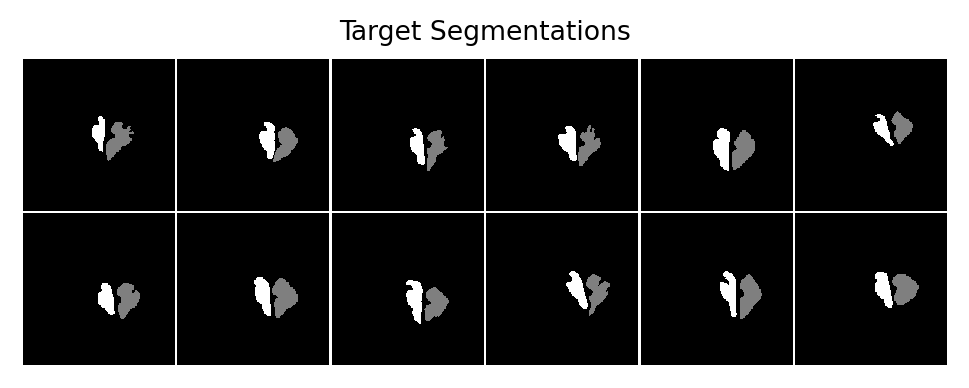

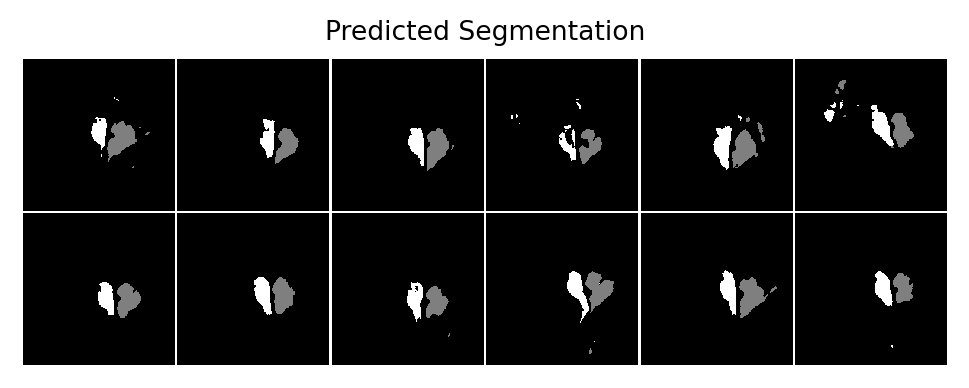

In [ ]:
segment(images, model_path, save_path, 0)